In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (3561).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (900).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (2429).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (1369).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (959).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (579).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (1475).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (1125).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (2803).jpg
/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/val/Cyst/Cyst- (1573).jpg
/kaggle/input/kindey-s

I0000 00:00:1735379948.362994      90 service.cc:145] XLA service 0x7c067c009c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735379948.363061      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1735379950.262085      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


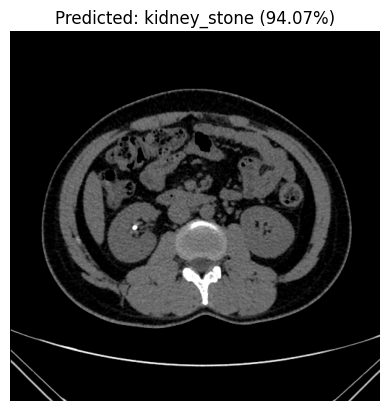

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-small


Processing small image...


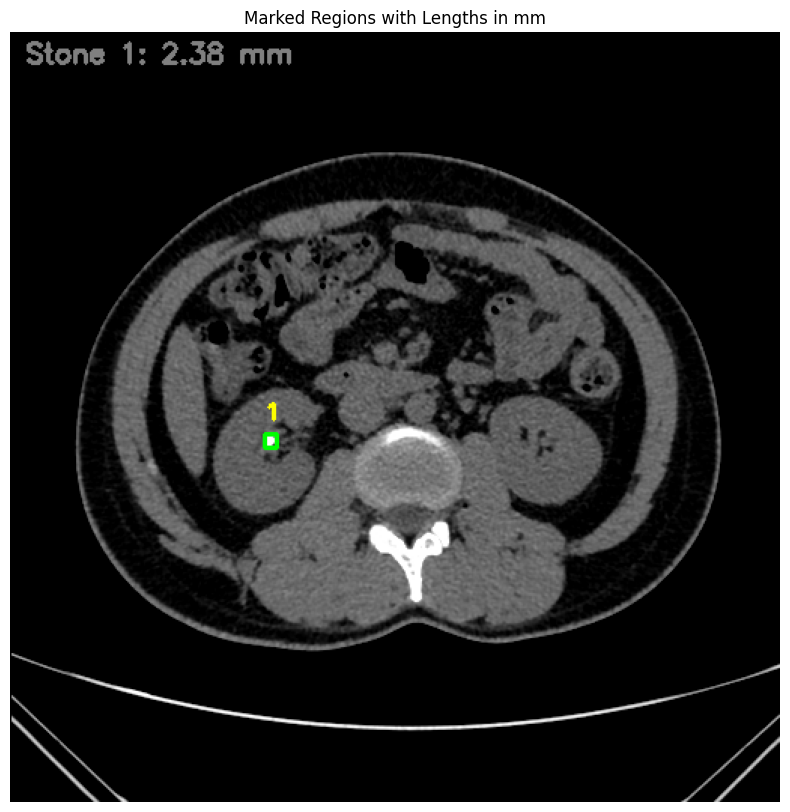

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()






def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((100, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 290), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/train/Stone/Stone- (1001).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


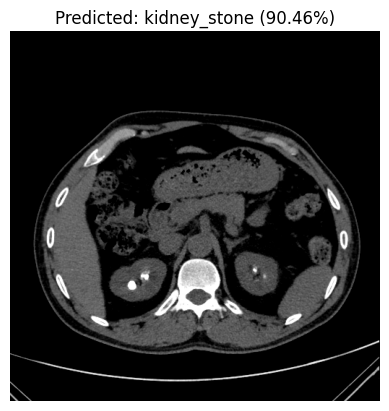

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-small


Processing small image...


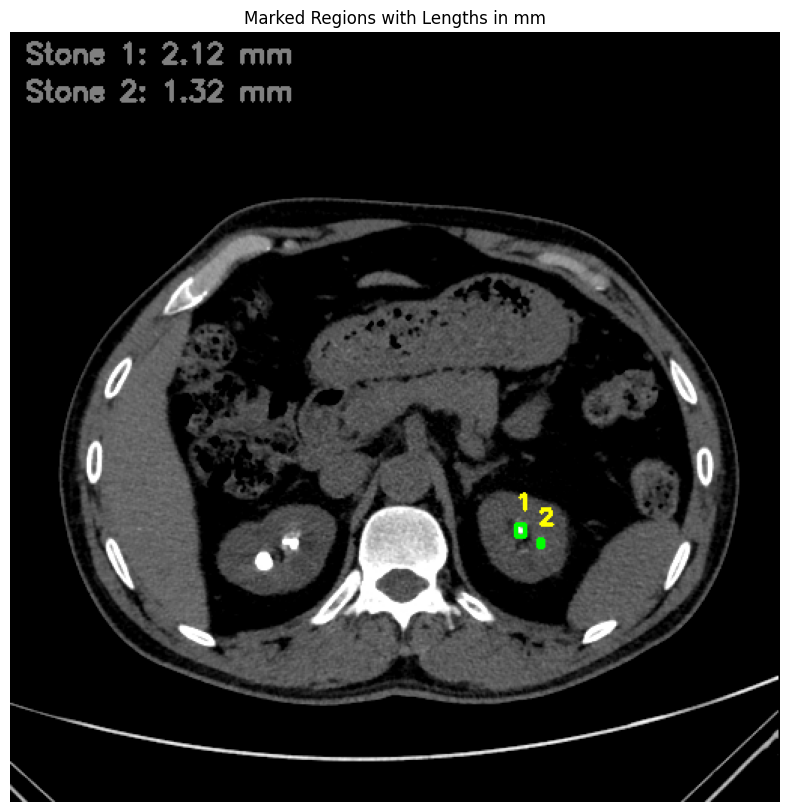

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()







def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((100, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 290), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1130).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


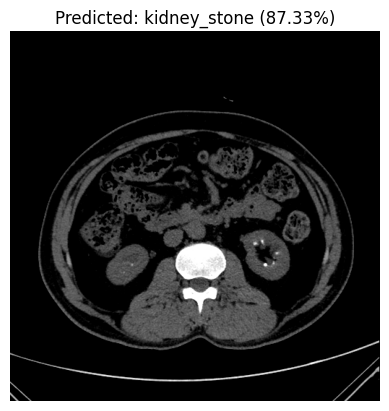

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-small


Processing small image...


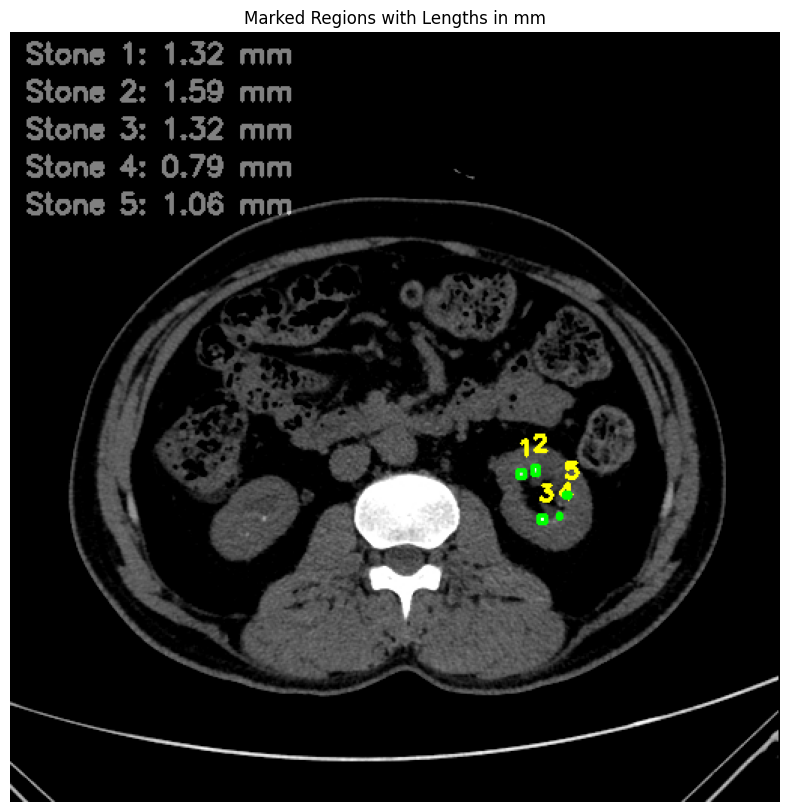

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((100, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 290), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1216).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


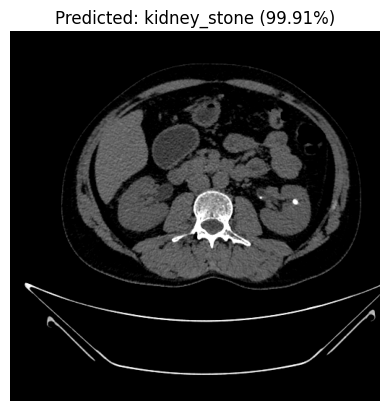

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-large


Processing medium-sized image...


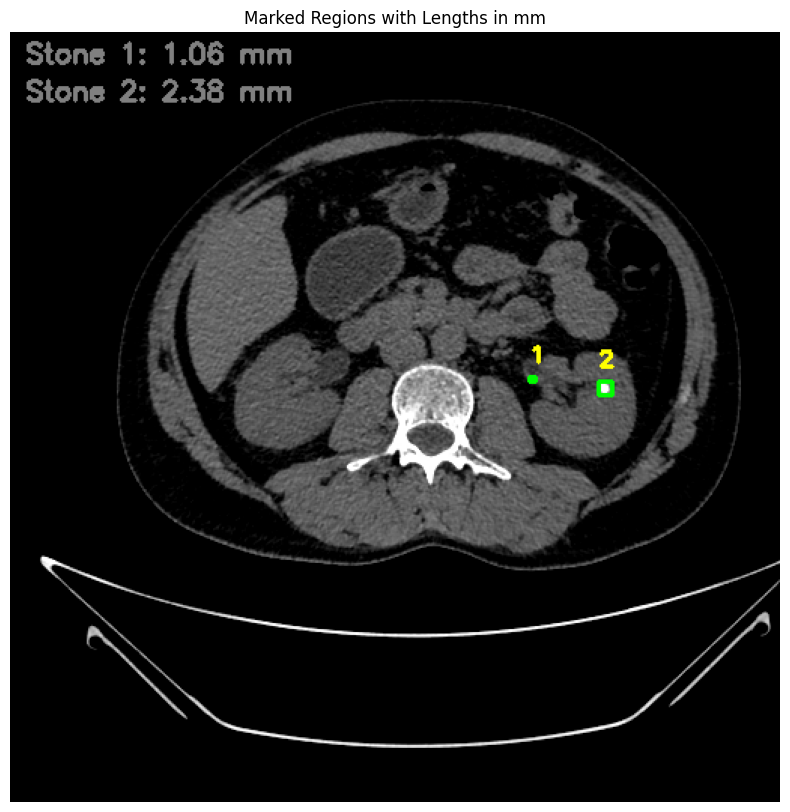

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    
    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()






def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((100, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 400), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1313).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


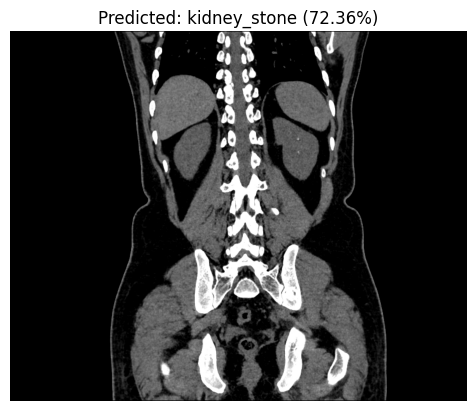

Original image size: (838, 679)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Cronical


Processing large image...


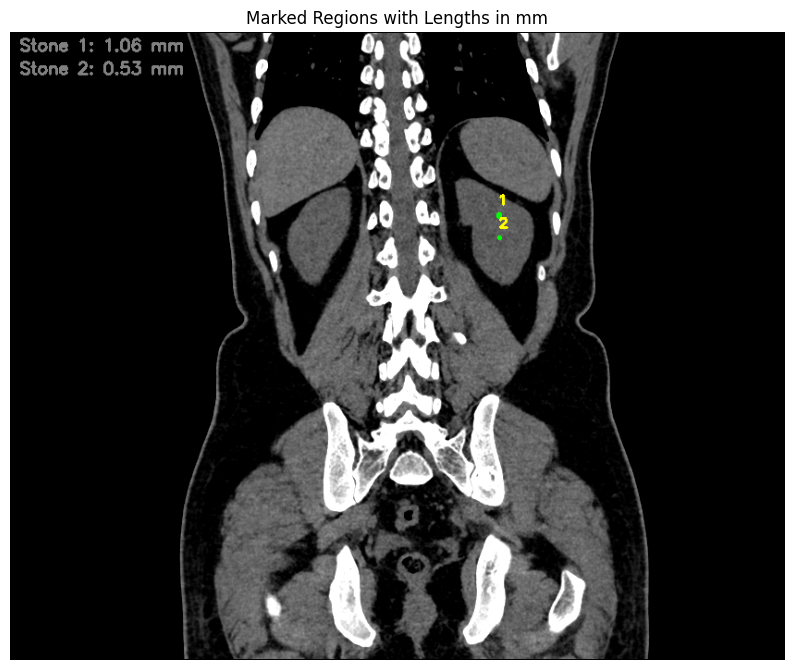

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()






def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((100, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (887).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


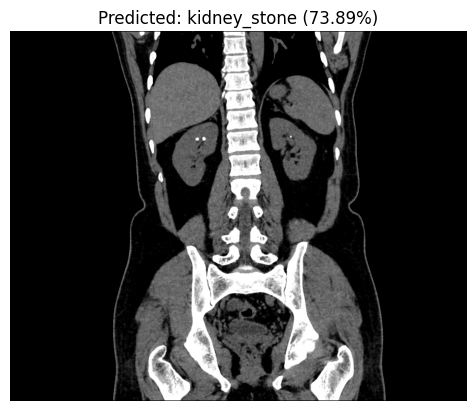

Original image size: (838, 679)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Cronical


Processing large image...


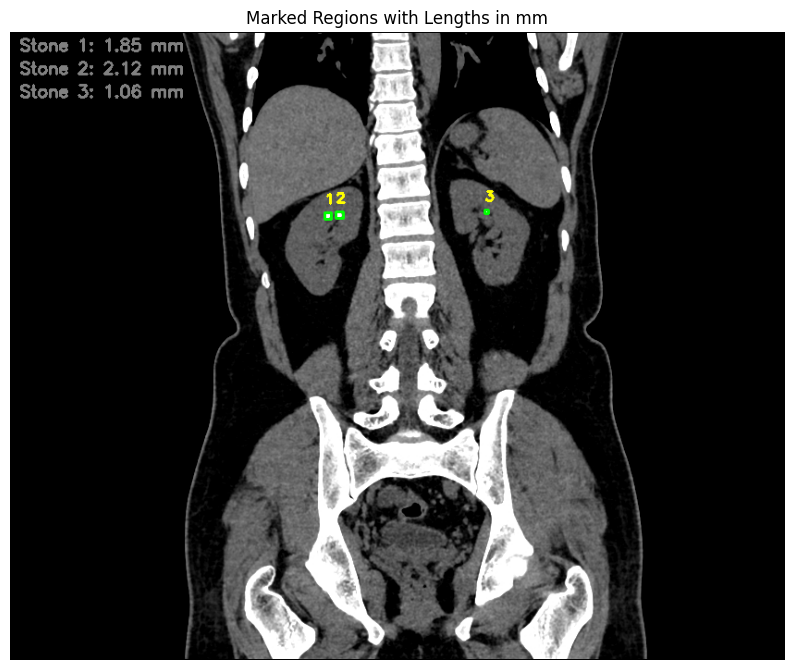

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((100, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (901).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


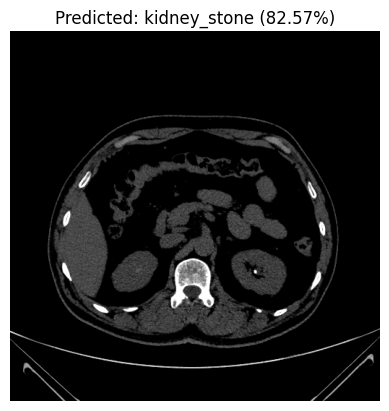

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-large


Processing medium-sized image...


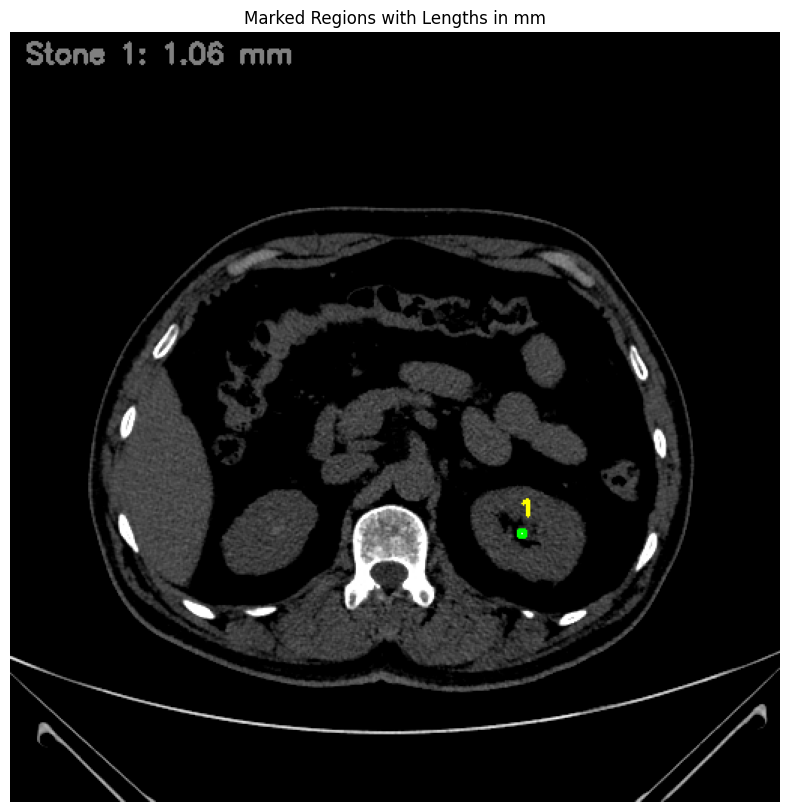

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (912).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


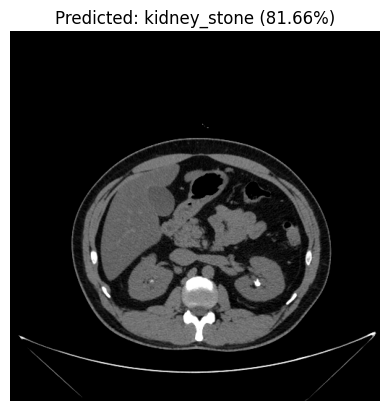

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-large


Processing medium-sized image...


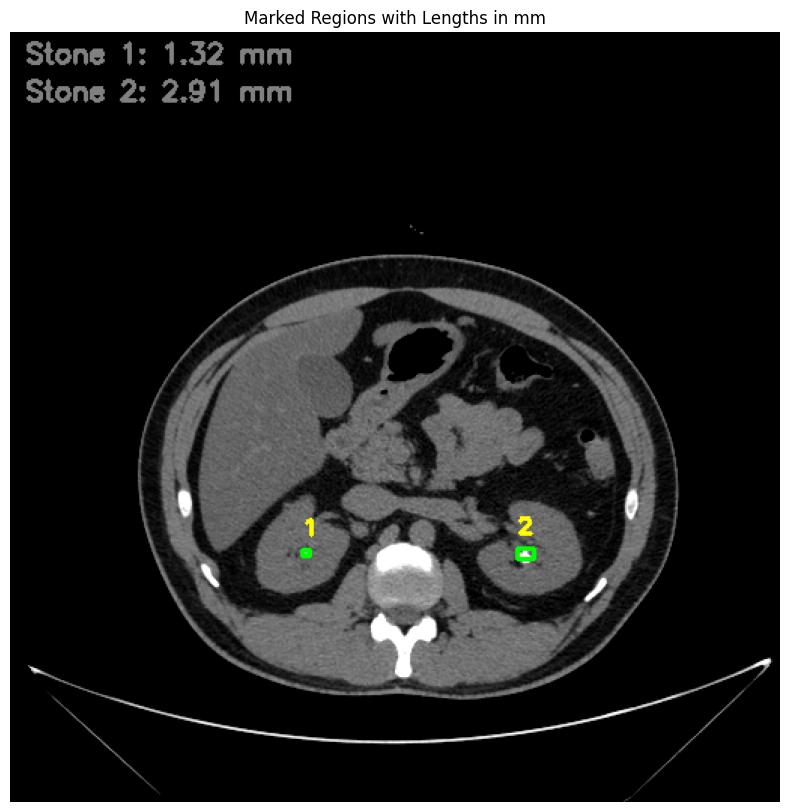

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (943).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


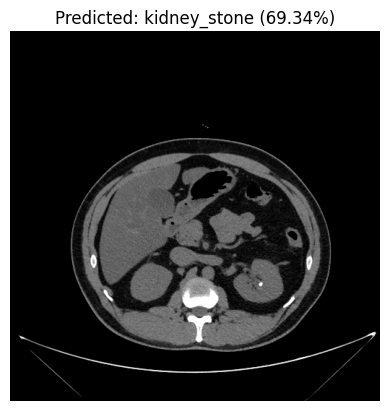

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-large


Processing medium-sized image...


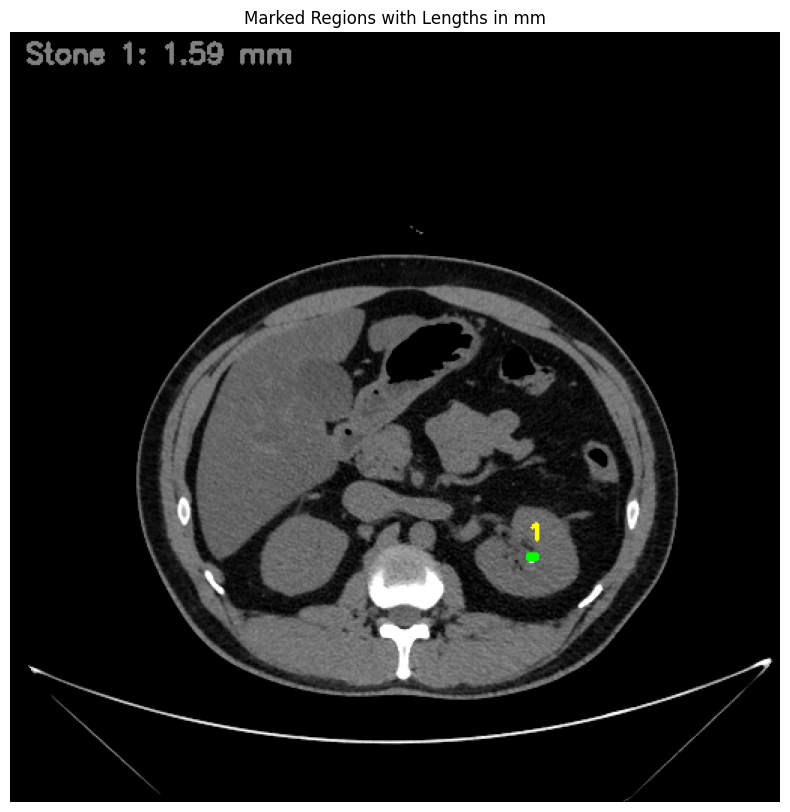

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (936).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


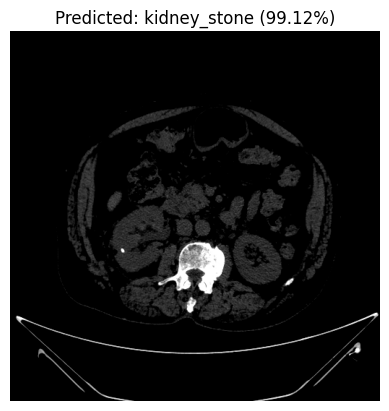

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-large


Processing medium-sized image...


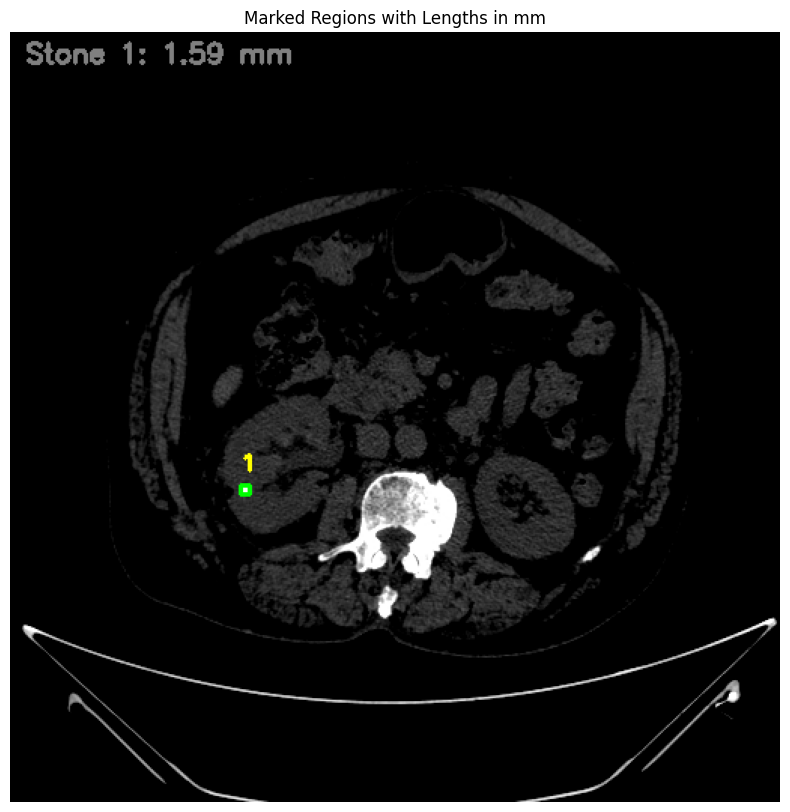

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (979).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


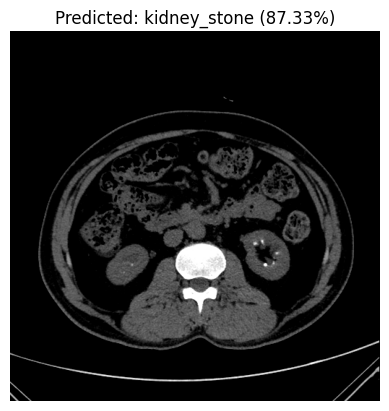

Original image size: (512, 512)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Axial-small


Processing small image...


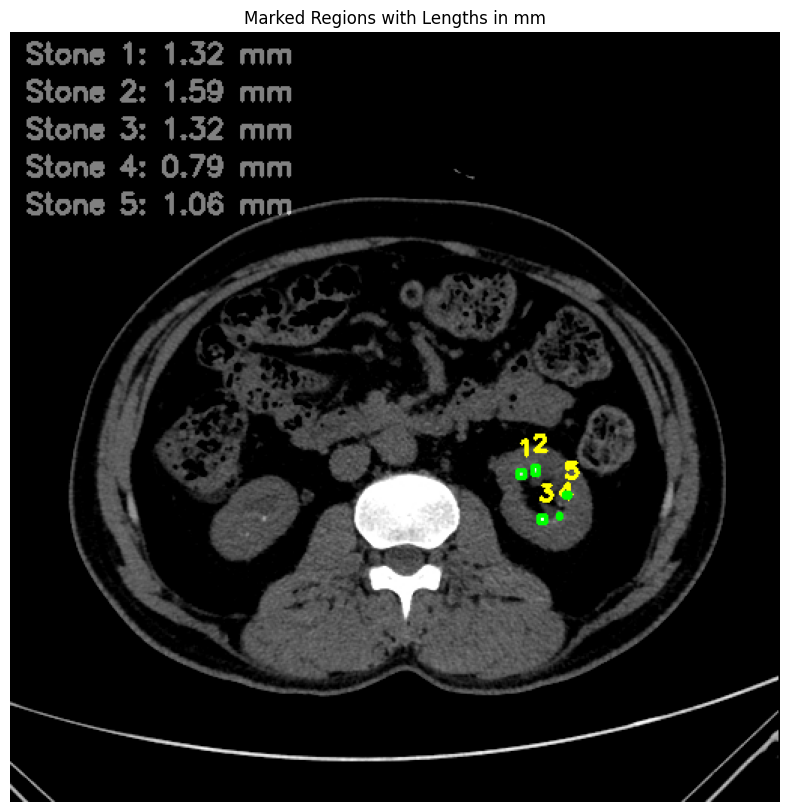

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 70)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1216).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


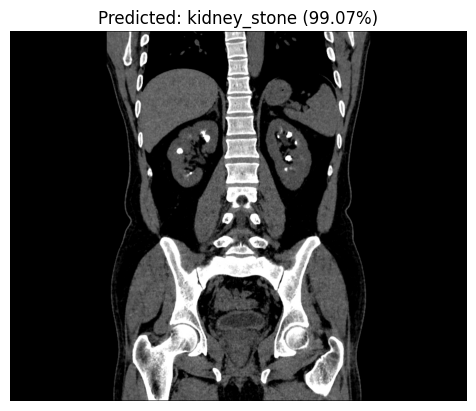

Original image size: (888, 719)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Cronical


Processing large image...


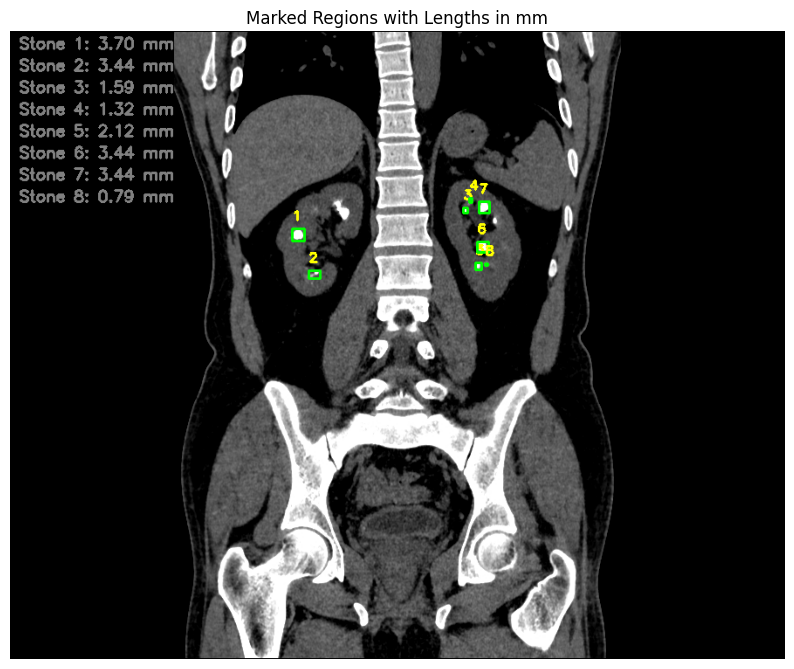

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 160)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1275).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


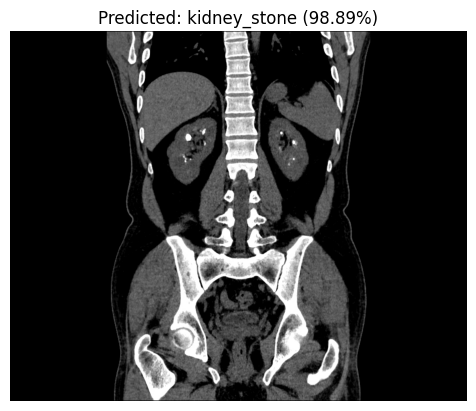

Original image size: (888, 719)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Cronical


Processing large image...


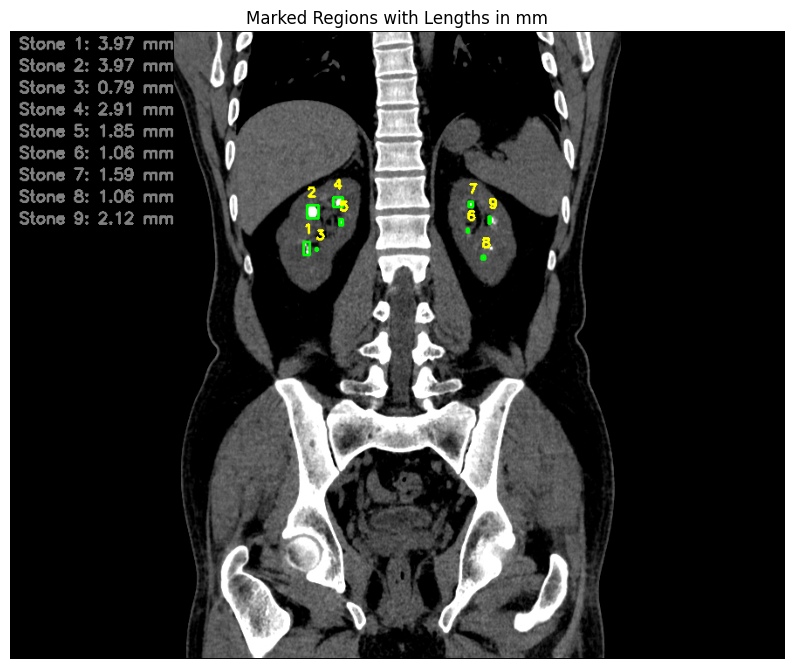

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 160)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1285).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


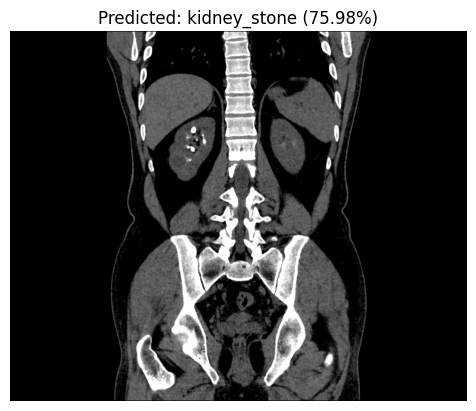

Original image size: (888, 719)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Cronical


Processing large image...


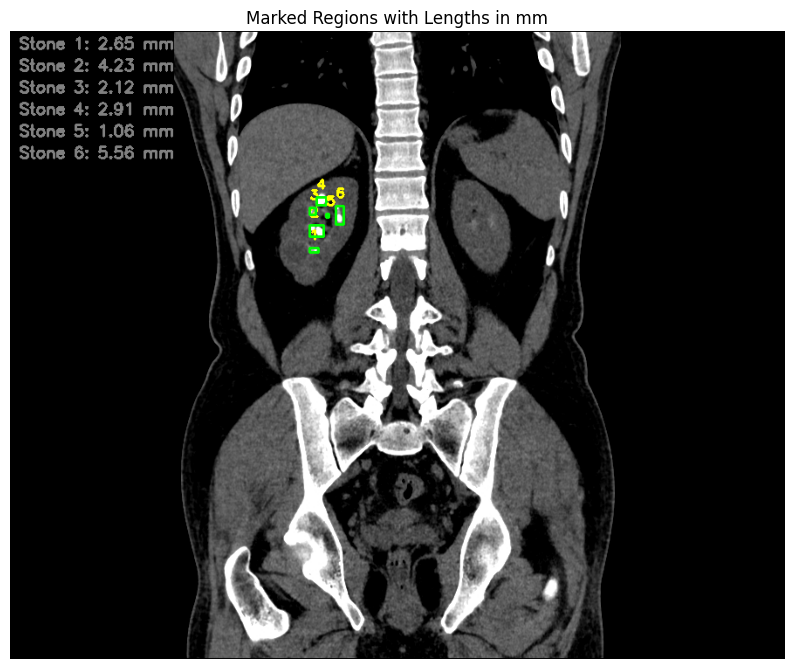

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()



def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 160)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1291).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


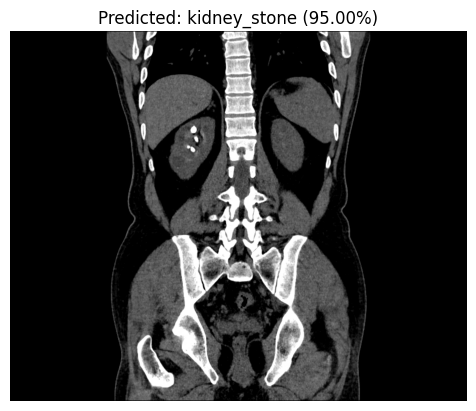

Original image size: (888, 719)


Enter the type of CT image(Axial-small,Axial-large,Cronical) Cronical


Processing large image...


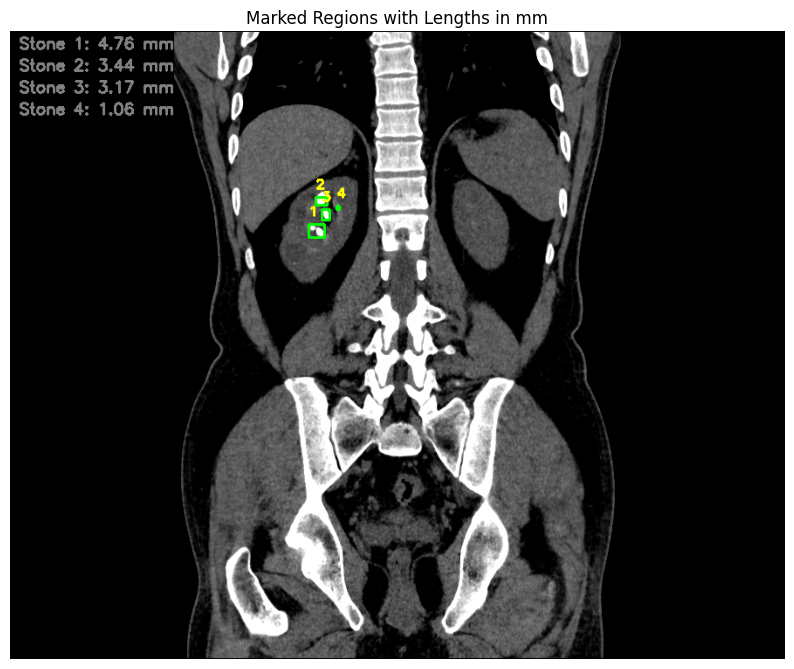

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()





def execute_based_on_size(image_path, image_size,labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels=="Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 160)
    elif labels=="Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 100)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1293).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels=input("Enter the type of CT image(Axial-small,Axial-large,Cronical)");
    execute_based_on_size(image_path, original_size,labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


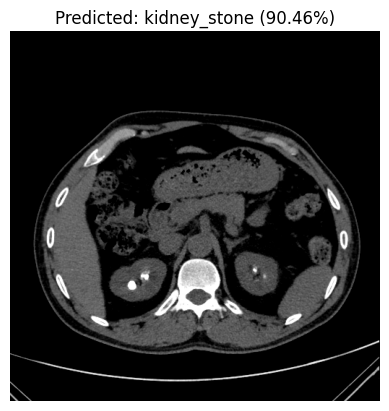

Original image size: (512, 512)


Enter the type of CT image (Axial-small, Axial-large, Cronical):  Axial-small


Processing small image...


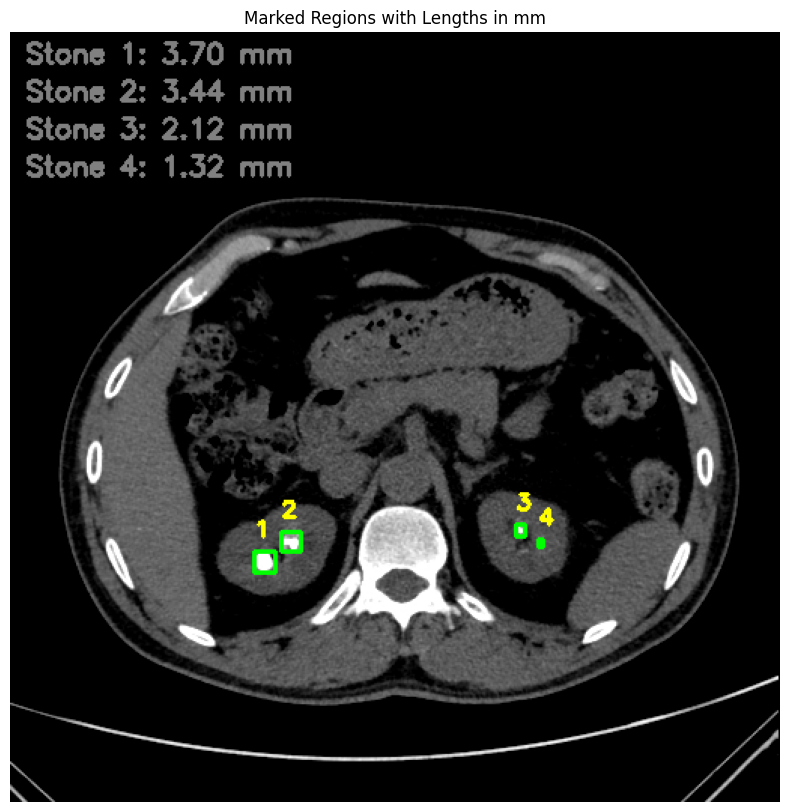

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/keras/keras/default/1/final_kidney_stone_model (1).keras')  # Update with the correct model file path

# Classes (match these with your dataset's folder names)
classes = ['normal', 'kidney_stone']  # Update based on your dataset structure


def predict_image(image_path):
    """Predicts the class of an image using the trained model."""
    image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
    image_array = img_to_array(image) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    confidence = predictions[0][predicted_index]
    predicted_label = classes[predicted_index]

    # Get the original size of the image
    with Image.open(image_path) as img:
        original_size = img.size  # (width, height)

    return predicted_label, confidence, original_size


class ImageProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image_pil = Image.open(image_path)
        self.dpi = self.image_pil.info.get('dpi', (96, 96))[0]  # Default DPI to 96 if not available
        self.conversion_factor = 25.4 / self.dpi  # Conversion factor (mm per pixel)

        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    def process_image(self, x_range, y_range, min_area_threshold, max_area_threshold):
            blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
            x1, x2 = max(0, x_range[0]), min(self.gray.shape[1], x_range[1])
            y1, y2 = max(0, y_range[0]), min(self.gray.shape[0], y_range[1])
            roi = cleaned[y1:y2, x1:x2]
        
            contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            # Sort contours based on the x-coordinate of the bounding box (or other criteria like area)
            contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
        
            stone_details = []
            stone_counter = 1  # Start numbering from 1
        
            for contour in contours:
                area = cv2.contourArea(contour)
                if min_area_threshold <= area <= max_area_threshold:
                    x, y, w, h = cv2.boundingRect(contour)
                    x += x1
                    y += y1
                    length_px = max(w, h)
                    length_mm = length_px * self.conversion_factor
                    stone_details.append((stone_counter, length_mm, (x, y, w, h)))
        
                    # Draw rectangle and number on the stone
                    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle in green
                    cv2.putText(self.image, str(stone_counter), (x, y - 10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)  # Number in yellow color
        
                    stone_counter += 1  # Increment the counter for the next stone
        
            # Overlay the lengths on the image top
            overlay = np.zeros_like(self.image)
            y_offset = 20
            for num, length, _ in stone_details:
                text = f"Stone {num}: {length:.2f} mm"
                cv2.putText(overlay, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                y_offset += 25
        
            # Combine the overlay with the image
            self.image = cv2.addWeighted(self.image, 1, overlay, 0.5, 0)
        
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
            plt.title("Marked Regions with Lengths in mm")
            plt.axis("off")
            plt.show()




def execute_based_on_size(image_path, image_size, labels):
    processor = ImageProcessor(image_path)
    width, height = image_size

    if labels == "Cronical":
        print("Processing large image...")
        processor.process_image((300, 550), (190, 290), 0.01, 160)
    elif labels == "Axial-small":
        print("Processing small image...")
        processor.process_image((90, 400), (200, 370), 0.00001, 150)
    else:
        print("Processing medium-sized image...")
        processor.process_image((150, 380), (170, 350), 0.1, 70)


# Test the function
image_path = '/kaggle/input/kindey-stone-dataset-splitted/Kindey_Stone_Dataset/test/Stone/Stone- (1130).jpg'  # Update with the path to your image
predicted_label, confidence, original_size = predict_image(image_path)

# Display the image and prediction
image = load_img(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence * 100:.2f}%)")
plt.show()

print(f"Original image size: {original_size}")

if predicted_label == 'kidney_stone':
    labels = input("Enter the type of CT image (Axial-small, Axial-large, Cronical): ")
    execute_based_on_size(image_path, original_size, labels)
